In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import time
import pandas as pd
import json
from IPython.display import clear_output

In [2]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import random;
import math;

In [3]:
num_epochs = 20;
batch_size = 100;
learning_rate = 0.01;

In [4]:
test_set = torchvision.datasets.FashionMNIST(                                # preparing FashionMNIST  data for test
    root = './data/FashionMNIST',
    train = False,                        
    download = True,
    transform = transforms.Compose([      
        transforms.ToTensor()                                 
    ])
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size) # DataLoader provides iterators over the dataset

train_set = torchvision.datasets.FashionMNIST(                                # preparing FashionMNIST  data for train
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class CNN(nn.Module):
    def __init__(self,hl):                                  # the parameter h is the number of hidden layers
        super(CNN, self).__init__()                         
        self.hl=hl
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),     #input is in channels - out channels
            nn.BatchNorm2d(16),                             #input is  number of features                           
            nn.ReLU(),
            nn.MaxPool2d(2))                                #input is kernel_size                      
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        if(hl==2):
          self.fc = nn.Linear(7*7*32, 10)
        elif(hl==1):
          self.fc=nn.Linear(7*7*64,10)
        else:
          self.fc=nn.Linear(28*28,10)
        
    def forward(self, x):
        if(self.hl==2):
          out = self.layer1(x)
          out = self.layer2(out)
          out = out.view(out.size(0), -1) 
          out = self.fc(out)
        elif(self.hl==1):
          out = self.layer1(x)
          out = out.view(out.size(0), -1)
          out = self.fc(out)
        else:
          out = x.view(x.size(0), -1)                        #reshape
          out = self.fc(out)
        return out

In [14]:
def getAcc(cnn,test_loader):
  cnn.eval()                                   #predict test data ,get the accuracy of test
  correct = 0
  total = 0
  epoch_num_correct=0
  for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1) #Get the output label by taking the max from the one-hot outputs
    total += labels.size(0)
    correct += (predicted == labels).sum()
  return (float(correct)/total)

In [15]:
def test1(cnn1,ds,test_loader,num_epochs):            # train the cnn1 using ds in num_epoch iteration and plot the accuracy of test_loader on trained cnn1.
  criterion = nn.CrossEntropyLoss();                                         #loss function
  optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate);         #optimization method 
  accL=[]
  accTrainer=[]
  losses = [];
  for epoch in range(num_epochs):                     
      epoch_num_correct=0;
      for i, (images, labels) in enumerate(ds):
          images = Variable(images.float())
          labels = Variable(labels)
          optimizer.zero_grad()                                           #Zero out the gradients in the optimizer
          outputs = cnn1(images)
          loss = criterion(outputs, labels)                               #Calculate the loss based on the outputs
          loss.backward()                                                 #Backpropagate the gradients
          optimizer.step()                                                #Update the parameters
          
          losses.append(loss.item()); 
          epoch_num_correct+=outputs.argmax(dim=1).eq(labels).sum().item()
      accuracy = epoch_num_correct / len(ds.dataset)
      print ('Epoch : %d/%d'%(epoch+1, num_epochs))
      print("Training accuracy:%.4f"%(accuracy))
      acc= getAcc(cnn1,test_loader)
      print("test accuracy:%.4f"%(acc))

      accTrainer.append(accuracy)
      accL.append( acc);


  plt.xlabel('epoch')
  plt.ylabel(' accuracy')
  plt.plot(range(0,num_epochs), accL,color = 'red', label = 'test')
  plt.plot(range(0,num_epochs), accTrainer, color = 'blue', label = 'train')
  plt.legend()
  plt.show()

Epoch : 1/20
Training accuracy:0.8397
test accuracy:0.8545
Epoch : 2/20
Training accuracy:0.8864
test accuracy:0.8818
Epoch : 3/20
Training accuracy:0.8982
test accuracy:0.8881
Epoch : 4/20
Training accuracy:0.9067
test accuracy:0.8858
Epoch : 5/20
Training accuracy:0.9137
test accuracy:0.8910
Epoch : 6/20
Training accuracy:0.9170
test accuracy:0.8927
Epoch : 7/20
Training accuracy:0.9219
test accuracy:0.8920
Epoch : 8/20
Training accuracy:0.9232
test accuracy:0.8911
Epoch : 9/20
Training accuracy:0.9263
test accuracy:0.8933
Epoch : 10/20
Training accuracy:0.9305
test accuracy:0.8951
Epoch : 11/20
Training accuracy:0.9324
test accuracy:0.8917
Epoch : 12/20
Training accuracy:0.9326
test accuracy:0.9021
Epoch : 13/20
Training accuracy:0.9347
test accuracy:0.8983
Epoch : 14/20
Training accuracy:0.9375
test accuracy:0.8985
Epoch : 15/20
Training accuracy:0.9392
test accuracy:0.8945
Epoch : 16/20
Training accuracy:0.9404
test accuracy:0.8973
Epoch : 17/20
Training accuracy:0.9404
test accur

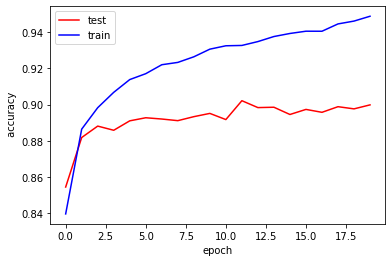

In [16]:
cnn = CNN(2);                       #cnn using ReLU -two hidden layer
test1(cnn,train_loader,test_loader,num_epochs)

Epoch : 1/20
Training accuracy:0.8494
test accuracy:0.8473
Epoch : 2/20
Training accuracy:0.8858
test accuracy:0.8689
Epoch : 3/20
Training accuracy:0.8978
test accuracy:0.8705
Epoch : 4/20
Training accuracy:0.9041
test accuracy:0.8692
Epoch : 5/20
Training accuracy:0.9088
test accuracy:0.8773
Epoch : 6/20
Training accuracy:0.9123
test accuracy:0.8796
Epoch : 7/20
Training accuracy:0.9149
test accuracy:0.8801
Epoch : 8/20
Training accuracy:0.9182
test accuracy:0.8796
Epoch : 9/20
Training accuracy:0.9209
test accuracy:0.8746
Epoch : 10/20
Training accuracy:0.9234
test accuracy:0.8824
Epoch : 11/20
Training accuracy:0.9230
test accuracy:0.8826
Epoch : 12/20
Training accuracy:0.9244
test accuracy:0.8847
Epoch : 13/20
Training accuracy:0.9265
test accuracy:0.8830
Epoch : 14/20
Training accuracy:0.9280
test accuracy:0.8865
Epoch : 15/20
Training accuracy:0.9281
test accuracy:0.8892
Epoch : 16/20
Training accuracy:0.9301
test accuracy:0.8830
Epoch : 17/20
Training accuracy:0.9306
test accur

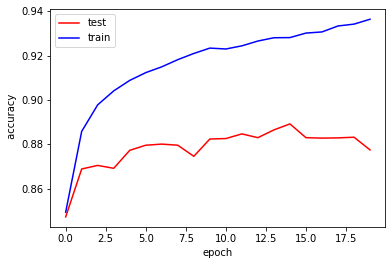

'criterion = nn.CrossEntropyLoss();\noptimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);\naccL=[]\naccTrainer=[]\nlosses = [];\n# print(len(train_set.train_data))\nfor epoch in range(num_epochs):\n    epoch_num_correct=0;\n    for i, (images, labels) in enumerate(train_loader):\n        images = Variable(images.float())\n        labels = Variable(labels)\n        \n        # Forward + Backward + Optimize\n        optimizer.zero_grad()\n        outputs = cnn(images)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        \n        losses.append(loss.item()); #epoch_loss += loss.item() *\n        epoch_num_correct+=outputs.argmax(dim=1).eq(labels).sum().item()\n        # if (i+1) % 100 == 0:\n\n            # print (\'Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f\' \n                  #  %(epoch+1, num_epochs, i+1, len(train_loader.dataset)//batch_size, loss.item()))\n    accuracy = epoch_num_correct / len(train_loader.dataset)\n    

In [25]:
cnn = CNN(1);  #cnn using ReLU -one  hidden layer
test1(cnn,train_loader,test_loader,num_epochs)

Epoch : 1/20
Training accuracy:0.8113
test accuracy:0.8304
Epoch : 2/20
Training accuracy:0.8386
test accuracy:0.8364
Epoch : 3/20
Training accuracy:0.8448
test accuracy:0.8399
Epoch : 4/20
Training accuracy:0.8471
test accuracy:0.8408
Epoch : 5/20
Training accuracy:0.8486
test accuracy:0.8395
Epoch : 6/20
Training accuracy:0.8499
test accuracy:0.8394
Epoch : 7/20
Training accuracy:0.8508
test accuracy:0.8384
Epoch : 8/20
Training accuracy:0.8517
test accuracy:0.8384
Epoch : 9/20
Training accuracy:0.8523
test accuracy:0.8382
Epoch : 10/20
Training accuracy:0.8530
test accuracy:0.8379
Epoch : 11/20
Training accuracy:0.8537
test accuracy:0.8370
Epoch : 12/20
Training accuracy:0.8542
test accuracy:0.8366
Epoch : 13/20
Training accuracy:0.8546
test accuracy:0.8363
Epoch : 14/20
Training accuracy:0.8550
test accuracy:0.8359
Epoch : 15/20
Training accuracy:0.8555
test accuracy:0.8357
Epoch : 16/20
Training accuracy:0.8560
test accuracy:0.8359
Epoch : 17/20
Training accuracy:0.8564
test accur

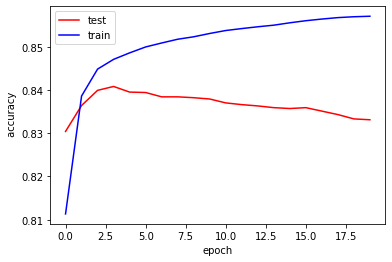

In [27]:
cnn = CNN(0);             #cnn using ReLU -no hidden layer
test1(cnn,train_loader,test_loader,num_epochs)

In [ ]:
# Activation

In [19]:
class CNN_activation(nn.Module):            # cnn 1 hidden layer with the parameter h=1 : Sigmoid ,h=2 :ReLU, h=0:Tanh as activation function
    def __init__(self,hl):
        super(CNN_activation, self).__init__()
        self.hl=hl

        if(hl==2):
              self.layer1 = nn.Sequential(
              nn.Conv2d(1, 16, kernel_size=5, padding=2),
              nn.BatchNorm2d(16),

              nn.ReLU(),
              nn.MaxPool2d(2))
        elif(hl==1):
              self.layer1 = nn.Sequential(
              nn.Conv2d(1, 16, kernel_size=5, padding=2),
              nn.BatchNorm2d(16),

              nn.Sigmoid(),
              nn.MaxPool2d(2))   
        else:
              self.layer1 = nn.Sequential(
              nn.Conv2d(1, 16, kernel_size=5, padding=2),
              nn.BatchNorm2d(16),

              nn.Tanh(),
              nn.MaxPool2d(2))
        self.fc=nn.Linear(7*7*64,10)

        
    def forward(self, x):
          out = self.layer1(x)
          out = out.view(out.size(0), -1)
          out = self.fc(out)
          return out

Epoch : 1/50
Training accuracy:0.8390
test accuracy:0.8458
Epoch : 2/50
Training accuracy:0.8802
test accuracy:0.8723
Epoch : 3/50
Training accuracy:0.8897
test accuracy:0.8792
Epoch : 4/50
Training accuracy:0.8964
test accuracy:0.8755
Epoch : 5/50
Training accuracy:0.8996
test accuracy:0.8746
Epoch : 6/50
Training accuracy:0.9016
test accuracy:0.8799
Epoch : 7/50
Training accuracy:0.9057
test accuracy:0.8709
Epoch : 8/50
Training accuracy:0.9049
test accuracy:0.8688
Epoch : 9/50
Training accuracy:0.9071
test accuracy:0.8823
Epoch : 10/50
Training accuracy:0.9094
test accuracy:0.8760
Epoch : 11/50
Training accuracy:0.9109
test accuracy:0.8724
Epoch : 12/50
Training accuracy:0.9109
test accuracy:0.8813
Epoch : 13/50
Training accuracy:0.9136
test accuracy:0.8774
Epoch : 14/50
Training accuracy:0.9147
test accuracy:0.8762
Epoch : 15/50
Training accuracy:0.9155
test accuracy:0.8705
Epoch : 16/50
Training accuracy:0.9101
test accuracy:0.8748
Epoch : 17/50
Training accuracy:0.9141
test accur

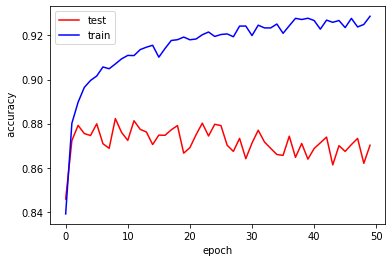

In [23]:
cnn2 = CNN_activation(0);   #cnn using Tanh -one hidden layer
test1(cnn2,train_loader,test_loader,50)

Epoch : 1/50
Training accuracy:0.7579
test accuracy:0.8404
Epoch : 2/50
Training accuracy:0.8638
test accuracy:0.8663
Epoch : 3/50
Training accuracy:0.8841
test accuracy:0.8766
Epoch : 4/50
Training accuracy:0.8934
test accuracy:0.8843
Epoch : 5/50
Training accuracy:0.8988
test accuracy:0.8825
Epoch : 6/50
Training accuracy:0.9042
test accuracy:0.8786
Epoch : 7/50
Training accuracy:0.9080
test accuracy:0.8717
Epoch : 8/50
Training accuracy:0.9115
test accuracy:0.8786
Epoch : 9/50
Training accuracy:0.9120
test accuracy:0.8778
Epoch : 10/50
Training accuracy:0.9117
test accuracy:0.8661
Epoch : 11/50
Training accuracy:0.9143
test accuracy:0.8648
Epoch : 12/50
Training accuracy:0.9182
test accuracy:0.8672
Epoch : 13/50
Training accuracy:0.9213
test accuracy:0.8665
Epoch : 14/50
Training accuracy:0.9226
test accuracy:0.8784
Epoch : 15/50
Training accuracy:0.9242
test accuracy:0.8814
Epoch : 16/50
Training accuracy:0.9271
test accuracy:0.8794
Epoch : 17/50
Training accuracy:0.9294
test accur

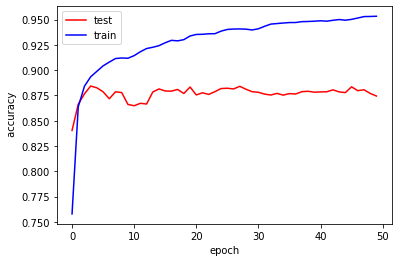

In [30]:
cnn2 = CNN_activation(1); #cnn using Sigmoid -one hidden layer
test1(cnn2,train_loader,test_loader,50)

Epoch : 1/50
Training accuracy:0.8415
test accuracy:0.8630
Epoch : 2/50
Training accuracy:0.8852
test accuracy:0.8622
Epoch : 3/50
Training accuracy:0.8937
test accuracy:0.8776
Epoch : 4/50
Training accuracy:0.9013
test accuracy:0.8850
Epoch : 5/50
Training accuracy:0.9052
test accuracy:0.8895
Epoch : 6/50
Training accuracy:0.9088
test accuracy:0.8863
Epoch : 7/50
Training accuracy:0.9126
test accuracy:0.8817
Epoch : 8/50
Training accuracy:0.9143
test accuracy:0.8830
Epoch : 9/50
Training accuracy:0.9155
test accuracy:0.8819
Epoch : 10/50
Training accuracy:0.9174
test accuracy:0.8821
Epoch : 11/50
Training accuracy:0.9202
test accuracy:0.8836
Epoch : 12/50
Training accuracy:0.9200
test accuracy:0.8860
Epoch : 13/50
Training accuracy:0.9225
test accuracy:0.8827
Epoch : 14/50
Training accuracy:0.9218
test accuracy:0.8810
Epoch : 15/50
Training accuracy:0.9230
test accuracy:0.8753
Epoch : 16/50
Training accuracy:0.9237
test accuracy:0.8808
Epoch : 17/50
Training accuracy:0.9258
test accur

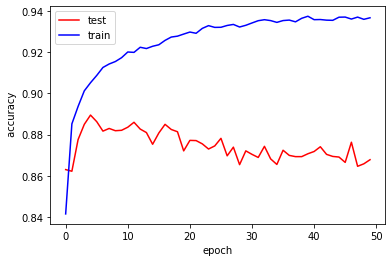

In [31]:
cnn2 = CNN_activation(2);#cnn using ReLU -one hidden layer
test1(cnn2,train_loader,test_loader,50)

In [32]:
train_set800 = torchvision.datasets.FashionMNIST( 
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [33]:
a=[[],[],[],[],[],[],[],[],[],[]]
for i in range(0,len(train_set800)):
  if(len(a[train_set800[i][1]])<800):    #select only 800 of each class item
    a[train_set800[i][1]].append(i)

m=torch.utils.data.Subset(train_set800,a[0]+a[1]+a[2]+a[3]+a[4]+a[5]+a[6]+a[7]+a[8]+a[9])
train800_loader = torch.utils.data.DataLoader(m, batch_size = batch_size,shuffle=True)

Epoch : 1/20
Training accuracy:0.7228
test accuracy:0.7767
Epoch : 2/20
Training accuracy:0.8476
test accuracy:0.8466
Epoch : 3/20
Training accuracy:0.8720
test accuracy:0.8549
Epoch : 4/20
Training accuracy:0.8862
test accuracy:0.8579
Epoch : 5/20
Training accuracy:0.8975
test accuracy:0.8634
Epoch : 6/20
Training accuracy:0.9041
test accuracy:0.8646
Epoch : 7/20
Training accuracy:0.9137
test accuracy:0.8652
Epoch : 8/20
Training accuracy:0.9185
test accuracy:0.8567
Epoch : 9/20
Training accuracy:0.9233
test accuracy:0.8572
Epoch : 10/20
Training accuracy:0.9269
test accuracy:0.8552
Epoch : 11/20
Training accuracy:0.9316
test accuracy:0.8625
Epoch : 12/20
Training accuracy:0.9336
test accuracy:0.8642
Epoch : 13/20
Training accuracy:0.9449
test accuracy:0.8610
Epoch : 14/20
Training accuracy:0.9423
test accuracy:0.8349
Epoch : 15/20
Training accuracy:0.9386
test accuracy:0.8572
Epoch : 16/20
Training accuracy:0.9483
test accuracy:0.8570
Epoch : 17/20
Training accuracy:0.9400
test accur

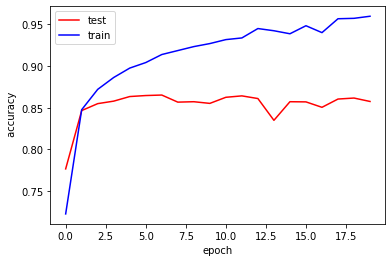

In [34]:
cnn = CNN(1); #cnn using ReLU -one hidden layer 
num_epochs=20
test1(cnn,train800_loader,test_loader,num_epochs)